In [180]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords, wordnet

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score

# import pickle
# import pickletools

In [2]:
most_recent_extract = '2023-06-11 16:25'
df = pd.read_csv(f'data/reddit_posts_raw_{most_recent_extract}.csv')

In [3]:
df.shape

(1971, 6)

In [4]:
df.head(1)

,subreddit,id,created_utc,title,selftext,top_comment_text
0,dating,1471ube,2023-06-11 18:49:33,Am I Clueless?,So there is this girl I’ve known my whole life...,NaN


### Self-text only

In [5]:
X = pd.Series(df['selftext'])
y = df['subreddit'].map({'dating': 0,
                    'datingoverthirty':1})

### Self Text and Top Comment - Alternative Path

In [6]:
# df['self_text_and_comment'] = df['self_text'].astype(str) + df['top_comment_text'].astype(str)
# X = pd.Series(df['self_text_and_comment'])
# y = df['subreddit'].map({'dating': 0,
#                    'datingoverthirty':1})

### Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)
# X_train.to_pickle('./pickled_models/X_train.pkl')
# X_test.to_pickle('./pickled_models/X_test.pkl')
# y_train.to_pickle('./pickled_models/y_train.pkl')
# y_test.to_pickle('./pickled_models/y_test.pkl')

# X_train = pd.read_pickle('./pickled_models/X_train.pkl')
# X_test = pd.read_pickle('./pickled_models/X_test.pkl')
# y_train = pd.read_pickle('./pickled_models/y_train.pkl')
# y_test = pd.read_pickle('./pickled_models/y_test.pkl')

#### Baseline

> The majority class holds 50.63% of responses.  This is the baseline score to beat.

> Even class distribution makes a 75/25 train test split possible.

In [8]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(y_test)
dummy_accuracy = accuracy_score(y_test, dummy_preds)
dummy_accuracy

0.5091277890466531

## Baseline Investigation with Standard Vectorizers

#### CountVectorizer

In [9]:
cvec0 = CountVectorizer() #standard CountVectorizer
cvec0.fit(X_train)
# pickle.dump(cvec0, open('./pickled_models/cvec0_baseline', 'wb'))

CountVectorizer()

> See Model Investigaion for Investigations

#### Tf-Idf Vectorizer

In [10]:
tvec0 = TfidfVectorizer()
tvec0.fit(X_train)
# pickle.dump(tvec0, open('./pickled_models/tvec0_baseline', 'wb'))

TfidfVectorizer()

> See Model Investigation for Investigations

## Modeling

#### Stemming and Lematizing

In [11]:
p_stemmer = PorterStemmer()
def stem_post(post):
    split_post = post.split(' ')
    return ' '.join([p_stemmer.stem(word) for word in split_post])
#cite 6/9 Breakfast Hour

In [12]:
# pickle.dump(stem_post, open('./pickled_models/function_stem_post.pkl', 'wb'))

In [13]:
lemmatizer = WordNetLemmatizer()
# cite: Lesson 504 NLP 1 - Modified to handle complete words.
def lemmatize_post(post):
    mapper = { 
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    post_split = post.split(' ')
    post_tokens = [(token, tag) for token, tag in nltk.pos_tag(post_split)]
    post_lem = []
    for token in post_tokens:
        pos = mapper.get(token[1][0])
        # post_lem.append((token[0],pos) if pos != None else (token[0]))
        post_lem.append(lemmatizer.lemmatize(token[0], pos) if pos != None else token[0])
    return ' '.join(post_lem).lower()

In [14]:
# pickle.dump(lemmatize_post, open('./pickled_models/function_lemmatize_post', 'wb'))

### Multiple Estimator Class

In [15]:
# Evaluating multiple classifiers in the same RandomSearchCV, trying different combinations of Tfidf / CountVectorizer and LogisticRegression() / MultinomialNB
# Inspiration: Wrapper Class (https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers).  Content: DSI Lesson 507 on OOP (https://git.generalassemb.ly/bobadams1/507-lesson-object-oriented-programming)
'''
Notes from Inspiration above (no copy-paste):
1. Need BaseEstimator() as the base class for all sklearn estimators - as a stand in for the estimator being selected
2. The class only really needs to to have self and the estimator as objects in the class.
3. The methods you would normally call for the estimator should be defined as functions within the model (don't forget to pass self every time!)
'''
from sklearn.base import BaseEstimator

class Multi_Classifier(BaseEstimator):
    def __init__(self, estimator = MultinomialNB()): #Multinomial NB as default
        self.estimator = estimator
    
    def fit(self, X, y): # interested in LogisticRegression, NB... both take primarily X,y
        return self.estimator.fit(X,y)

    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def score(self, X,y):
        return self.estimator.score(X,y)


#### Model Performance Capture

In [163]:
# Empty Data Frame to capture output from each model fit.
model_performance_capture = pd.DataFrame(columns = ['model_name', 'model', 'best_score','model_params', 'train_acuracy', 'test_accuracy', 'baseline_accuracy'])

In [156]:
# Evaluate Model Performance
def model_evaluation(model, model_name):
    
    # print(model_performance)
    
    #Print Model Evaluations to the screen
    print(f"Train-Test Accuracy Scores:\n  Train: {round(train_accy0,5)} \n  Test: {round(test_accy0,5)}\n  Baseline: {round(dummy_accuracy,5)}\n---")
    print(f"\n Classification Report:\n{classification_report(y_test, rs0.predict(X_test), digits = 4)}")
    print(f"\n---\nBest Parameters: \n{model.best_params_}")
    
    # Plot and Save the Confusion Matrix
    plt.figure(figsize = (8,5))
    ConfusionMatrixDisplay.from_predictions(y_test, preds0, cmap = 'YlOrBr', display_labels=['r/dating','r/datingoverthirty'])
    plt.title(f"Confusion Matrix: {model_name}")
    # plt.suptitle('Stop Words: English | Unigrams and Bigrams | Max Documents:90% | No Stem/Lem | LogisticRegression', y=0, fontsize = 9)
    plt.savefig(fname= f'./images/{model_name}_Confusion Matrix.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
    #Append results of key metrics to 
    # pd.concat(model_performance_capture,
    model_performance = pd.DataFrame({
        'model_name' : model_name,
        'model' : model,
        'best_score_CV' : model.best_score_,
        'model_params' : [model.best_params_],
        'train_acuracy' : model.score(X_train, y_train),
        'test_accuracy' : model.score(X_test, y_test),
        'baseline_accuracy' : dummy_accuracy
        })

    return model_performance

In [113]:
model_performance_capture.head()

,model_name,model,model_params,train_acuracy,test_accuracy,best_score,baseline_accuracy


## 01 - RandomSearch over Multiple Estimators with Tfidf Vectorization

#### Pipeline & Parameters

In [201]:
pipe1 = Pipeline([
    ('tvec' , TfidfVectorizer()),
    # ('sc', StandardScaler()),
    ('cls' , Multi_Classifier())
])

params1 = [# list of params... one for each estimator (order matters here). Cite: Tim Office Hours
    { 
        ## Logistic Regression
        'cls__estimator': [LogisticRegression()],
        'cls__estimator__C': np.linspace(0.9, 2, 10), 
        
        'tvec__preprocessor': [lemmatize_post],     # Lemmatizing showed the best results in initial testing
        # 'tvec__max_df': [1.0, 0.9],
        # 'tvec__max_features': [None, 5000],
        # 'tvec__min_df': [1],
        'tvec__ngram_range': [(1,2)],               #words and bigrams showed best results early
        'tvec__stop_words': ['english'],            #English stop words showed best results early.

        # 'cls__estimator__max_iter': 100,
        # 'cls__estimator__penalty': 'l2'
    }
        ,# Multinomial Naive Bayes
        {
        'cls__estimator': [MultinomialNB()],
            
         'tvec__preprocessor': [lemmatize_post],     # Lemmatizing showed the best results in initial testing
        # 'tvec__max_df': [1.0, 0.9],
        # 'tvec__max_features': [None, 5000],
        # 'tvec__min_df': [1],
        'tvec__ngram_range': [(1,2)],               #words and bigrams showed best results early
        'tvec__stop_words': ['english'],            #English stop words showed best results early.
            
    }
        ,#Kernelized SVM
        {
        'cls__estimator': [SVC()],
        'cls__estimator__C': np.linspace(0.05, 2, 10),
        'cls__estimator__degree': [2,3],
        'cls__estimator__kernel': ['poly','rbf'],
            
        'tvec__preprocessor': [lemmatize_post],     # Lemmatizing showed the best results in initial testing
        # 'tvec__max_df': [1.0, 0.9],
        # 'tvec__max_features': [None, 5000],
        # 'tvec__min_df': [1],
        'tvec__ngram_range': [(1,2)],               #words and bigrams showed best results early
        'tvec__stop_words': ['english'],            #English stop words showed best results early.
         
    }
]
# pipe1.get_params()

In [202]:
rs1 = RandomizedSearchCV(estimator=pipe0,
                        param_distributions=params0,
                        cv = 5,
                        n_iter = 100
                       )

#### Model Fitting

In [203]:
%time
rs1.fit(X_train, y_train)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words g

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('cls', Multi_Classifier())]),
                   n_iter=1,
                   param_distributions=[{'cls__estimator': [LogisticRegression()],
                                         'cls__estimator__C': array([0.9       , 1.02222222, 1.14444444, 1.26666667, 1.38888889,
       1.51111111, 1.63333333, 1.75555556, 1.87777778, 2.        ]),
                                         'tvec__ngram_range': [(1, 2)],
                                         'tvec__preprocessor':...
                                        {'cls__estimator': [SVC(C=1.1333333333333335,
                                                                degree=2)],
                                         'cls__estimator__C': array([0.05      , 0.26666667, 0.48333333, 0.7       , 0.91666667,
       1.13333333, 1.35      , 1.56666667, 1.78333333, 2.        ]),
                                         'cls__estimator__degree': [2, 3],
                                         'cls__estimator__kernel': ['poly',
                                                                    'rbf'],
                                         'tvec__ngram_range': [(1, 2)],
                                         'tvec__preprocessor': [<function lemmatize_post at 0x7fbf48805510>],
                                         'tvec__stop_words': ['english']}])

In [ ]:
# pickle.dump(rs1, open('./pickled_models/rs0.pkl', 'wb'))

#### Model Evaluation

Train-Test Accuracy Scores:
  Train: 0.98985 
  Test: 0.79716
  Baseline: 0.50913
---

 Classification Report:
              precision    recall  f1-score   support

           0     0.8319    0.7769    0.8034       242
           1     0.7978    0.8486    0.8224       251

    accuracy                         0.8134       493
   macro avg     0.8148    0.8127    0.8129       493
weighted avg     0.8145    0.8134    0.8131       493


---
Best Parameters: 
{'tvec__stop_words': 'english', 'tvec__preprocessor': <function lemmatize_post at 0x7fbf48805510>, 'tvec__ngram_range': (1, 2), 'cls__estimator__kernel': 'rbf', 'cls__estimator__degree': 2, 'cls__estimator__C': 1.1333333333333335, 'cls__estimator': SVC(C=1.1333333333333335, degree=2)}


<Figure size 800x500 with 0 Axes>

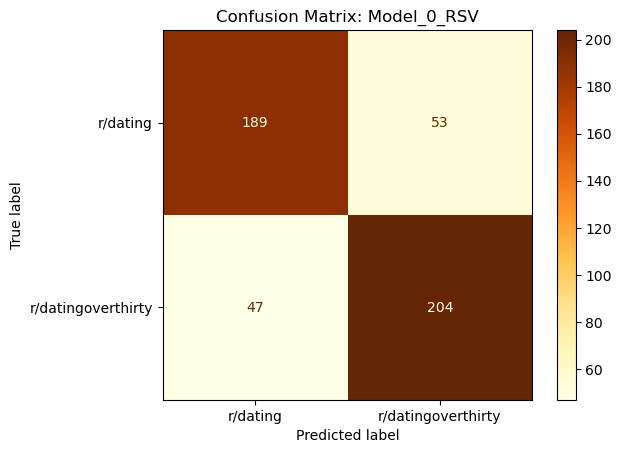

/var/folders/w7/4sqt0lt90t72lgqr2zq3p6l80000gn/T/ipykernel_33031/3165966032.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_capture.append(model_evaluation(rs0, 'Model_0_RSV'))


,model_name,model,best_score,model_params,train_acuracy,test_accuracy,baseline_accuracy,best_score_CV
0,Model_0_RSV,"RandomizedSearchCV(cv=5,\n e...",NaN,"{'tvec__stop_words': 'english', 'tvec__preproc...",1.0,0.813387,0.509128,0.794313


In [165]:
model_performance_capture.append(model_evaluation(rs1, 'Model_1_RSCV_Multi_Tfidf'))

## 02 - RandomSearchCV over Multiple Estimators with CountVectorization

In [177]:
pipe2 = Pipeline([
    ('cvec' , CountVectorizer()),
    ('cls' , Multi_Classifier())
])

params2 = [{ # list of params... one for each estimator (order matters here). Cite: Tim Office Hours
        ## Logistic Regression
        'cls__estimator': [LogisticRegression()],
        'cls__estimator__C': np.linspace(0.00001, 1, 10), 
        
        'cvec__max_df': [1.0, 0.9],
         'cvec__ngram_range': [(1, 1), (1,2)],
         'cvec__preprocessor': [None, stem_post, lemmatize_post],
         'cvec__stop_words': [None, 'english']          

        # 'cls__estimator__max_iter': 100,
        # 'cls__estimator__penalty': 'l2'
        },
        ## Multinomial Naive Bayes
        {
        'cls__estimator': [MultinomialNB()],
            
        'cvec__max_df': [1.0, 0.9],
         'cvec__ngram_range': [(1, 1), (1,2)],
         'cvec__preprocessor': [None, stem_post, lemmatize_post],
         'cvec__stop_words': [None, 'english']
            
},
        #Kernelized SVM
        {
         'cls__estimator': [SVC()],
         'cls__estimator__C': np.linspace(0.05, 2, 10),
         'cls__estimator__degree': [2,3],
         'cls__estimator__kernel': ['poly','rbf'],
            
         'cvec__max_df': [1.0, 0.9],
         'cvec__ngram_range': [(1, 1), (1,2)],
         'cvec__preprocessor': [None, stem_post, lemmatize_post],
         'cvec__stop_words': [None, 'english']
         
        }]

In [178]:
rs2 = RandomizedSearchCV(estimator=pipe1,
                        param_distributions=params1,
                        cv = 5,
                        n_iter = 100
                       )

In [179]:
%time
rs2.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('cls', Multi_Classifier())]),
                   n_iter=1,
                   param_distributions=[{'cls__estimator': [LogisticRegression()],
                                         'cls__estimator__C': array([1.0000e-05, 1.1112e-01, 2.2223e-01, 3.3334e-01, 4.4445e-01,
       5.5556e-01, 6.6667e-01, 7.7778e-01, 8.8889e-01, 1.0000e+00]),
                                         'cvec__max_df': [1.0, 0.9],
                                         'cvec__ng...
                                         'cls__estimator__C': array([0.05      , 0.26666667, 0.48333333, 0.7       , 0.91666667,
       1.13333333, 1.35      , 1.56666667, 1.78333333, 2.        ]),
                                         'cls__estimator__degree': [2, 3],
                                         'cls__estimator__kernel': ['poly',
                                                                    'rbf'],
                                         'cvec__max_df': [1.0, 0.9],
                                         'cvec__ngram_range': [(1, 1), (1, 2)],
                                         'cvec__preprocessor': [None,
                                                                <function stem_post at 0x7fbf4dfebb50>,
                                                                <function lemmatize_post at 0x7fbf48805510>],
                                         'cvec__stop_words': [None,
                                                              'english']}])

In [ ]:
model_performance_capture.append(model_evaluation(rs2, 'Model_2_RsCV_Multi_CVEC'))

## Tree-Based Models

### 03 - Bagged Trees

In [232]:
params3 = {
     'tvec__preprocessor': [None, stem_post, lemmatize_post],
     'tvec__max_df': [1.0, 0.9],
     'tvec__max_features': [None, 5000],
     'tvec__min_df': [1],
     'tvec__ngram_range': [(1, 2), (1, 2)],
     'tvec__stop_words': [None, 'english'],
     'bag__estimator__max_depth': np.arange(1, 12),
     'bag__estimator__min_samples_leaf': np.arange(1, 12, 2),
     'bag__n_estimators': [100]
}
tree = DecisionTreeClassifier()

pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(tree))
])
rs3 = RandomizedSearchCV(estimator=pipe3, param_distributions=params3, cv = 5, n_iter = 100)

In [230]:
rs3.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('bag',
                                              BaggingClassifier(estimator=DecisionTreeClassifier()))]),
                   n_iter=1,
                   param_distributions={'bag__estimator__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'bag__estimator__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11]),
                                        'bag__n_estimators': [100],
                                        'tvec__max_df': [1.0, 0.9],
                                        'tvec__max_features': [None, 5000],
                                        'tvec__min_df': [1],
                                        'tvec__ngram_range': [(1, 2), (1, 2)],
                                        'tvec__preprocessor': [None,
                                                               <function stem_post at 0x7fbf4dfebb50>,
                                                               <function lemmatize_post at 0x7fbf48805510>],
                                        'tvec__stop_words': [None, 'english']})

Train-Test Accuracy Scores:
  Train: 0.98985 
  Test: 0.79716
  Baseline: 0.50913
---

 Classification Report:
              precision    recall  f1-score   support

           0     0.8319    0.7769    0.8034       242
           1     0.7978    0.8486    0.8224       251

    accuracy                         0.8134       493
   macro avg     0.8148    0.8127    0.8129       493
weighted avg     0.8145    0.8134    0.8131       493


---
Best Parameters: 
{'tvec__stop_words': 'english', 'tvec__preprocessor': None, 'tvec__ngram_range': (1, 2), 'tvec__min_df': 1, 'tvec__max_features': None, 'tvec__max_df': 0.9, 'bag__n_estimators': 100, 'bag__estimator__min_samples_leaf': 9, 'bag__estimator__max_depth': 2}


<Figure size 800x500 with 0 Axes>

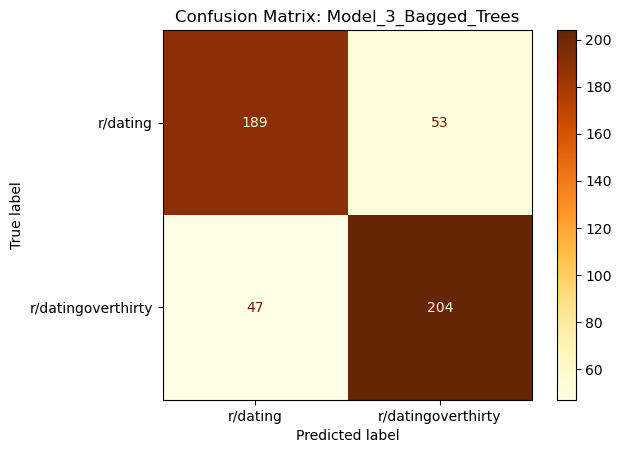

/var/folders/w7/4sqt0lt90t72lgqr2zq3p6l80000gn/T/ipykernel_33031/812298378.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_capture.append(model_evaluation(rs3, 'Model_3_Bagged_Trees'))


,model_name,model,best_score,model_params,train_acuracy,test_accuracy,baseline_accuracy,best_score_CV
0,Model_3_Bagged_Trees,"RandomizedSearchCV(cv=5,\n e...",NaN,"{'tvec__stop_words': 'english', 'tvec__preproc...",0.68065,0.6714,0.509128,0.674574


In [231]:
model_performance_capture.append(model_evaluation(rs3, 'Model_3_Bagged_Trees'))

## 04 - RandomForrest Classifier

In [236]:
params4 = {
    'tvec__preprocessor': [None, stem_post, lemmatize_post],
     'tvec__max_df': [1.0, 0.9],
     'tvec__max_features': [None, 5000],
     'tvec__min_df': [1],
     'tvec__ngram_range': [(1, 2), (1, 2)],
     'tvec__stop_words': [None, 'english'],
    
     'rfc__max_depth': [10,20,30],
     'rfc__min_samples_split': [2,4,8],
     'rfc__n_estimators': [100,200],
     'rfc__random_state': [2187]
}

pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier()),
])

rs4 = RandomizedSearchCV(estimator=pipe4, param_distributions=params4, n_iter = 1)

In [239]:
rs4.fit(X_train, y_train)

/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words g

RandomizedSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   n_iter=1,
                   param_distributions={'rfc__max_depth': [10, 20, 30],
                                        'rfc__min_samples_split': [2, 4, 8],
                                        'rfc__n_estimators': [100, 200],
                                        'rfc__random_state': [2187],
                                        'tvec__max_df': [1.0, 0.9],
                                        'tvec__max_features': [None, 5000],
                                        'tvec__min_df': [1],
                                        'tvec__ngram_range': [(1, 2), (1, 2)],
                                        'tvec__preprocessor': [None,
                                                               <function stem_post at 0x7fbf4dfebb50>,
                                                               <function lemmatize_post at 0x7fbf48805510>],
                                        'tvec__stop_words': [None, 'english']})

In [ ]:
model_performance_capture.append(model_evaluation(rs4, 'Model_4_Random_Forrest'))